In [1]:
import tensorflow as tf
from tensorflow.contrib import predictor

export_dir = "gs://neural-guidance-tensorflow/export/0311_michal_sr100_tpu_small_bs32_c1/1552376836/"
predict_fn = predictor.from_saved_model(export_dir)

INFO:tensorflow:Restoring parameters from gs://neural-guidance-tensorflow/export/0311_michal_sr100_tpu_small_bs32_c1/1552376836/variables/variables


In [2]:
from matplotlib import pyplot as plt
import numpy as np
import random

In [3]:
import sys 
sys.path.insert(0,'..')

In [4]:
from cnf_dataset import clauses_to_matrix
from dpll import DPLL, RandomClauseDPLL, MostCommonVarDPLL, RandomVarDPLL
from cnf import get_random_kcnf, CNF, get_sats_SR, get_pos_SR
from tqdm import tqdm
from collections import Counter

In [5]:
LIMIT_RUNS = 1000

In [6]:
def shorten_cnf(cnf: CNF):
    for c in cnf.clauses:
        if len(c) == 1:
            # print("Chosen lone clause", c[0])
            return shorten_cnf(cnf.set_var(c[0]))
    all_literals = set(x
                       for clause in cnf.clauses
                       for x in clause)
    for v in cnf.vars:
        if v in all_literals and (-v) not in all_literals:
            # print("Chosen lone literal", v)
            return shorten_cnf(cnf.set_var(v))
        if (-v) in all_literals and v not in all_literals:
            # print("Chosen lone literal", -v)
            return shorten_cnf(cnf.set_var(-v))
    return cnf

def make_normalized(cls):
    class NormalizedDPLL(cls):
        def run(self, cnf: CNF):
            assert isinstance(cnf, CNF)
            self.number_of_runs += 1
            if self.number_of_runs > LIMIT_RUNS:
                return None
            
            cnf = shorten_cnf(cnf)
            if cnf.is_true():
                return []
            elif cnf.is_false():
                return None

            sug_var = self.suggest(cnf)
            sug_cnf = cnf.set_var(sug_var)

            sug_res = self.run(sug_cnf)
            if sug_res is not None:
                return [sug_var] + sug_res

            not_sug_cnf = cnf.set_var(-sug_var)
            not_sug_res = self.run(not_sug_cnf)
            if not_sug_res is not None:
                self.number_of_errors += 1
                return [-sug_var] + not_sug_res
            return None
    NormalizedDPLL.__name__ = "Normalized{}".format(cls.__name__)
    return NormalizedDPLL

In [7]:
np.set_printoptions(precision=3, suppress=True)

In [8]:
import tensorflow as tf
import os

BATCH_SIZE = 1

In [9]:
# Because we have to pass full batch

logfile = open("/tmp/log_2", "w")
#import sys
#logfile = sys.stdout

class GraphBasedDPLL(DPLL):
    def suggest(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)
        
        policy_probs = predict_fn({"input": inputs})['policy_probabilities']
        
        print("CNF:", input_cnf, end=' ', file=logfile)
        print('cnf_clauses[0]', input_cnf.clauses, end=' ', file=logfile)
        print("probs:\n",  policy_probs[0], end='\n', file=logfile)
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        print("best_svar:", best_svar, file=logfile)
        # print("Chosen neural", best_svar)
        return best_svar

class MostCommonDPLL(DPLL):
    def suggest(self, cnf: CNF):
        counter = Counter()
        for clause in cnf.clauses:
            for svar in clause:
                counter[svar] += 1
        return counter.most_common(1)[0][0]

In [10]:
NormalizedGraphBasedDPLL = make_normalized(GraphBasedDPLL)
NormalizedMostCommonDPLL = make_normalized(MostCommonDPLL)

In [11]:
def compute_steps(sats, dpll_cls):
    steps = []
    errors = []
    solved = 0
    for sat in tqdm(sats):
        dpll = dpll_cls()
        res = dpll.run(sat)
        # assert res is not None
        if res is not None:
            steps.append(dpll.number_of_runs)
            errors.append(dpll.number_of_errors)
            solved += 1
    print("Within {} steps solved {} problems out of {}".format(LIMIT_RUNS, solved, len(sats)))
    return steps, errors

In [12]:
def compute_and_print_steps(sats, dpll_cls):
    steps, errors = compute_steps(sats, dpll_cls)
    print("#Sats: {}; avg step: {:.2f}; stdev step: {:.2f}; avg error: {:.2f}; stdev error: {:.2f}".format(
        len(steps), np.mean(steps), np.std(steps), np.mean(errors), np.std(errors)))
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.title("Steps of {}".format(dpll_cls.__name__))
    plt.hist(steps, bins=20) # range(2**(N+1)))
    plt.ylim((0, len(sats)))
    
    plt.subplot(1, 2, 2)
    plt.title("Errors of {}".format(dpll_cls.__name__))
    plt.hist(errors, bins=range(N+1))
    plt.ylim((0, len(sats)))
    plt.show()

In [13]:
def print_all(s, n, m, light=False):
    # def get_sats_SR(sample_number, min_variable_number, clause_number, max_variable_number=None):
    global S, N, M
    S = s
    N = n # number of clauses
    M = m # number of variables
    
    MAX_TRIES = 100000
    sats = []
    
    random.seed(1)
    np.random.seed(1)
    
    for index in range(MAX_TRIES):
        if len(sats) >= S:
            break
        sat = get_pos_SR(M, M, N)
        # if DPLL().run(sat) is not None:
        sats.append(sat)
    assert len(sats) == S
    # sats = get_sats_SR(S,M,N)
    # for sat in sats:
    #    print(sat)
    # assert len(sats) == S
    print("We have generated {} formulas".format(len(sats)))
    # compute_and_print_steps(sats, DPLL)
    # compute_and_print_steps(sats, SimplifiedGraphBasedDPLL)
    compute_and_print_steps(sats, NormalizedGraphBasedDPLL)
    
    # compute_and_print_steps(sats, SimplifiedMostCommonDPLL)
    compute_and_print_steps(sats, NormalizedMostCommonDPLL)
    logfile.flush()

  0%|          | 0/30 [00:00<?, ?it/s]

We have generated 30 formulas


100%|██████████| 30/30 [00:58<00:00,  1.75s/it]


Within 1000 steps solved 30 problems out of 30
#Sats: 30; avg step: 21.80; stdev step: 19.39; avg error: 0.60; stdev error: 0.66


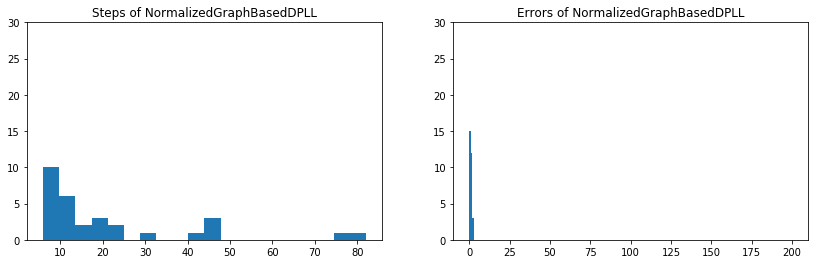

100%|██████████| 30/30 [00:00<00:00, 58.89it/s]


Within 1000 steps solved 30 problems out of 30
#Sats: 30; avg step: 19.93; stdev step: 14.34; avg error: 1.50; stdev error: 1.02


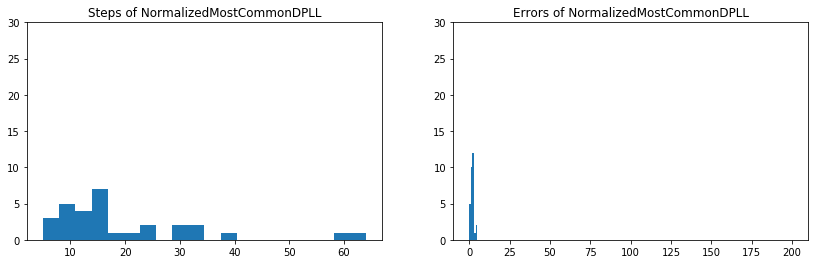

In [14]:
print_all(30, 200, 20)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:15<00:00,  1.32s/it]


Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 20.80; stdev step: 15.59; avg error: 0.50; stdev error: 0.67


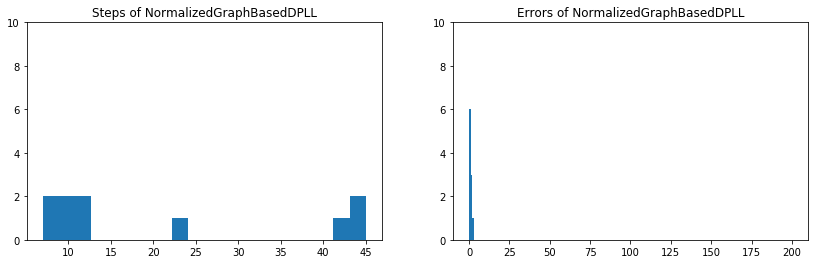

100%|██████████| 10/10 [00:00<00:00, 58.52it/s]


Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 17.30; stdev step: 9.95; avg error: 1.50; stdev error: 1.20


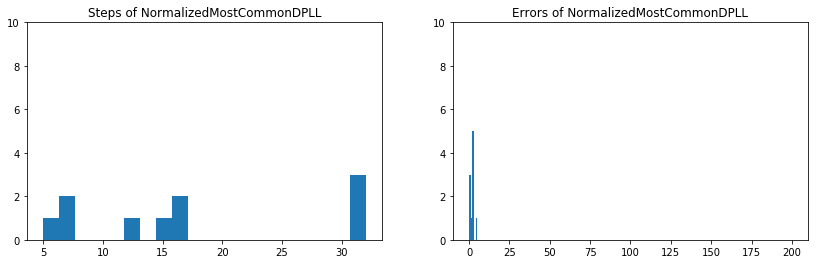

In [15]:
print_all(10, 200, 20)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 5.50; stdev step: 1.20; avg error: 0.00; stdev error: 0.00


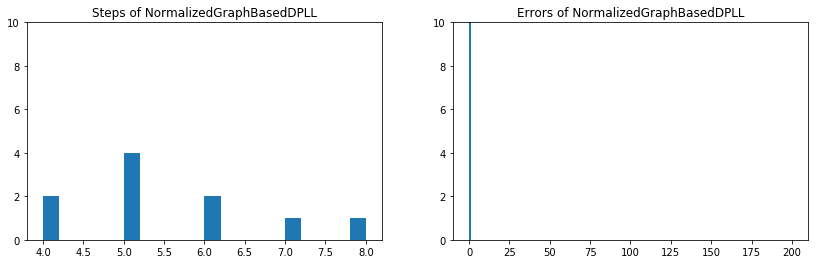

100%|██████████| 10/10 [00:00<00:00, 209.39it/s]


Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 8.30; stdev step: 3.58; avg error: 0.60; stdev error: 0.49


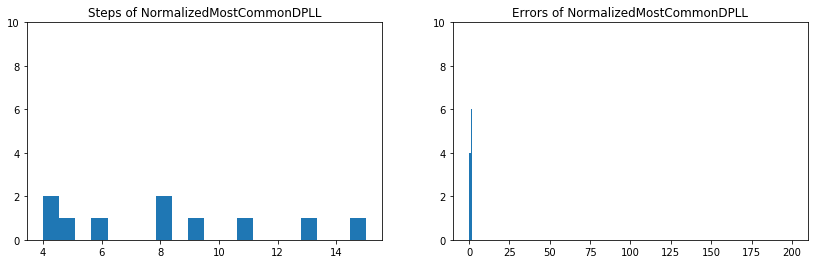

In [16]:
print_all(10, 200, 10)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:06<00:00,  1.83it/s]


Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 8.30; stdev step: 4.38; avg error: 0.30; stdev error: 0.46


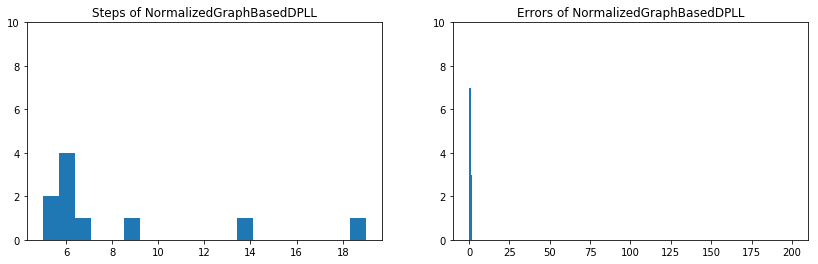

100%|██████████| 10/10 [00:00<00:00, 165.80it/s]


Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 9.70; stdev step: 5.35; avg error: 1.10; stdev error: 0.94


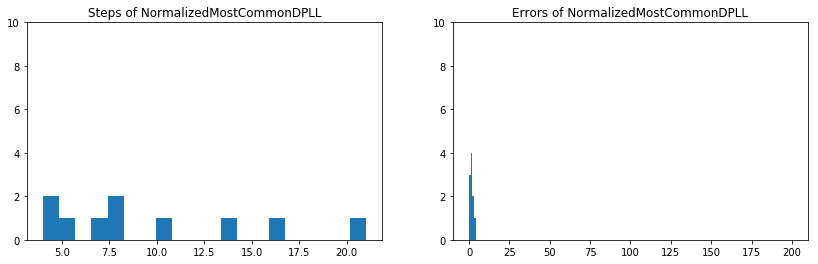

In [17]:
print_all(10, 200, 12)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:07<00:00,  1.45it/s]


Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 11.10; stdev step: 6.58; avg error: 0.40; stdev error: 0.49


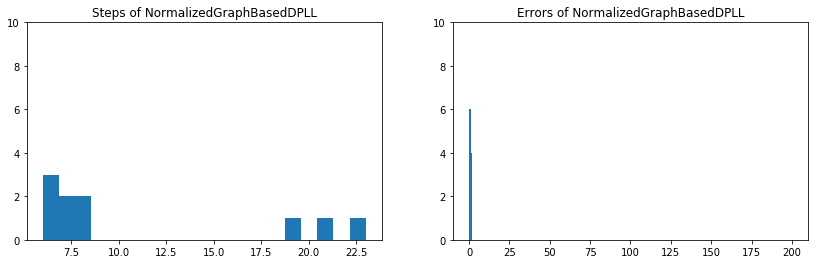

100%|██████████| 10/10 [00:00<00:00, 225.31it/s]


Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 8.10; stdev step: 2.26; avg error: 0.60; stdev error: 0.49


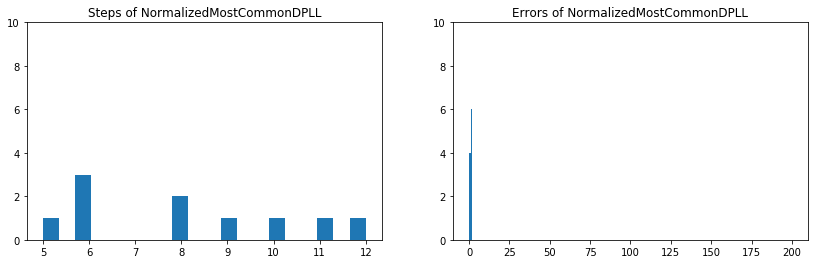

In [18]:
print_all(10, 200, 14)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:09<00:00,  1.13s/it]


Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 13.70; stdev step: 9.45; avg error: 0.60; stdev error: 0.66


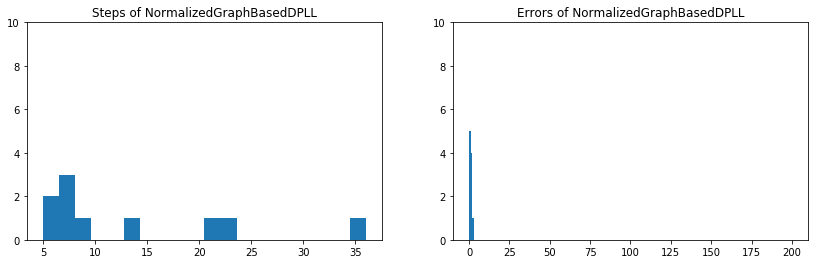

100%|██████████| 10/10 [00:00<00:00, 77.33it/s]


Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 15.30; stdev step: 9.52; avg error: 1.40; stdev error: 0.92


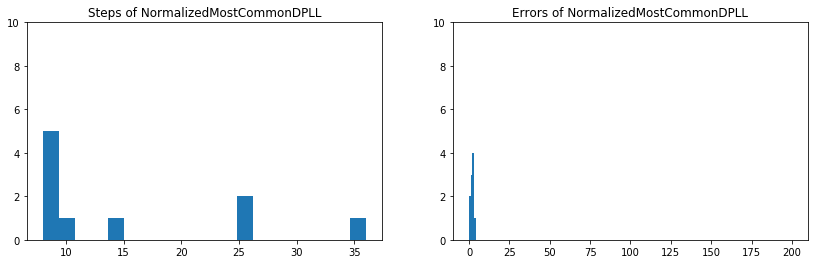

In [19]:
print_all(10, 200, 16)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 16.30; stdev step: 11.47; avg error: 0.60; stdev error: 0.80


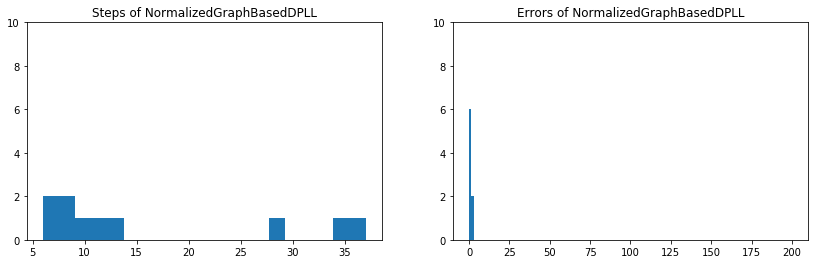

100%|██████████| 10/10 [00:00<00:00, 60.70it/s]


Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 17.10; stdev step: 12.08; avg error: 1.10; stdev error: 0.70


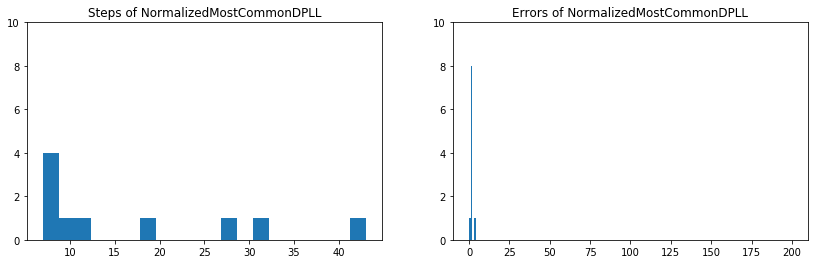

In [20]:
print_all(10, 200, 18)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:12<00:00,  1.02s/it]


Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 20.80; stdev step: 15.59; avg error: 0.50; stdev error: 0.67


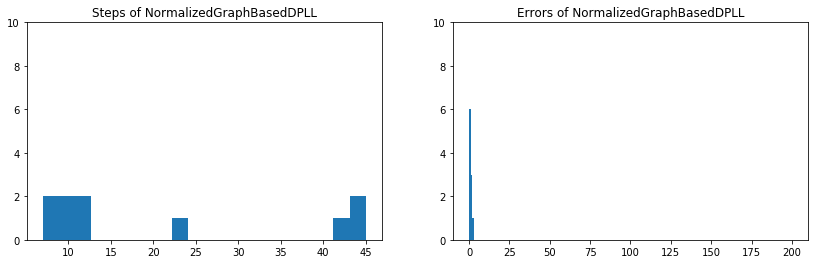

100%|██████████| 10/10 [00:00<00:00, 57.18it/s]


Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 17.30; stdev step: 9.95; avg error: 1.50; stdev error: 1.20


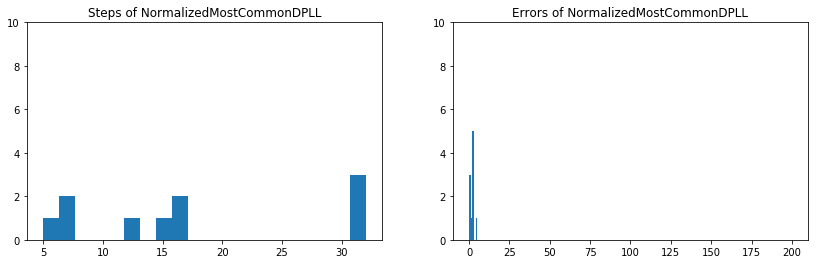

In [21]:
print_all(10, 200, 20)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:16<00:00,  1.64s/it]


Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 19.40; stdev step: 13.52; avg error: 0.70; stdev error: 0.78


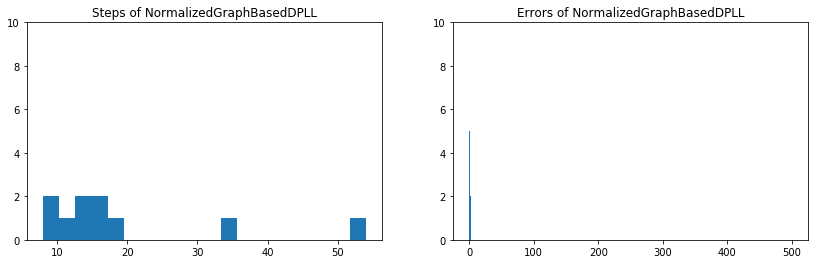

100%|██████████| 10/10 [00:00<00:00, 32.26it/s]


Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 22.70; stdev step: 14.46; avg error: 1.50; stdev error: 1.12


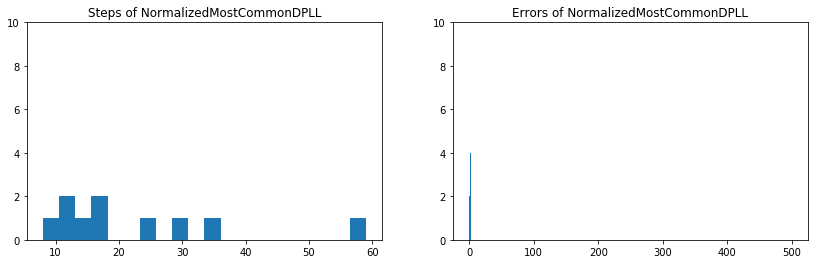

In [22]:
print_all(10, 500, 25, light=True)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:44<00:00,  3.42s/it]


Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 53.90; stdev step: 41.35; avg error: 0.90; stdev error: 0.70


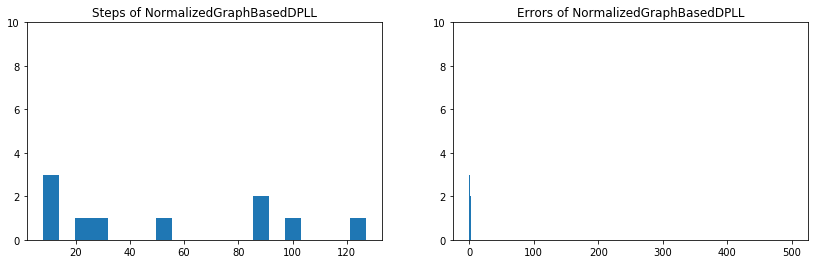

100%|██████████| 10/10 [00:01<00:00,  5.69it/s]


Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 54.80; stdev step: 42.94; avg error: 2.00; stdev error: 1.34


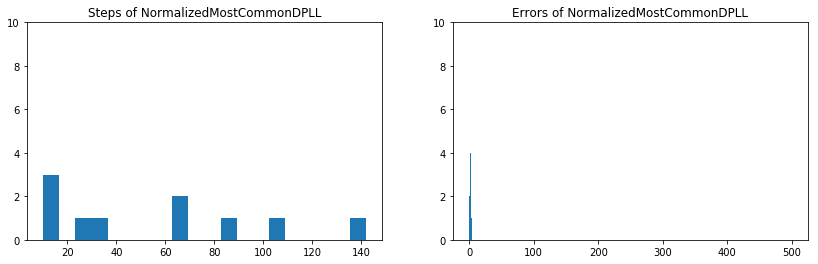

In [23]:
print_all(10, 500, 30, light=True)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:39<00:00,  3.44s/it]


Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 30.90; stdev step: 27.98; avg error: 0.30; stdev error: 0.46


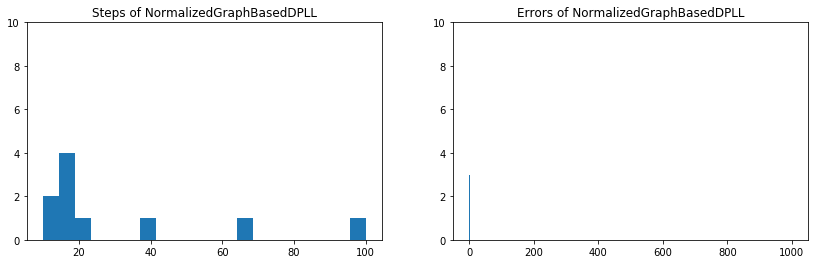

100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


Within 1000 steps solved 10 problems out of 10
#Sats: 10; avg step: 203.20; stdev step: 187.55; avg error: 2.90; stdev error: 1.45


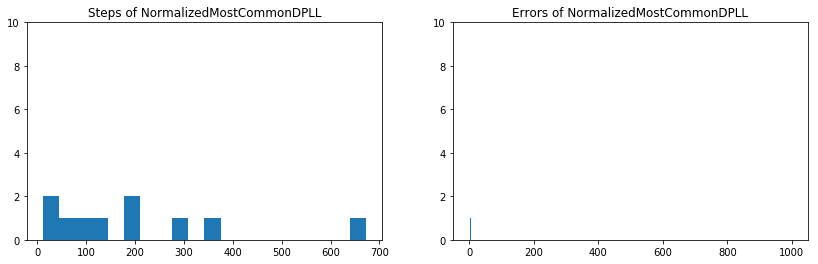

In [24]:
print_all(10, 1000, 40, light=True)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [05:35<00:00, 32.73s/it]


Within 1000 steps solved 9 problems out of 10
#Sats: 9; avg step: 218.67; stdev step: 278.92; avg error: 1.00; stdev error: 0.94


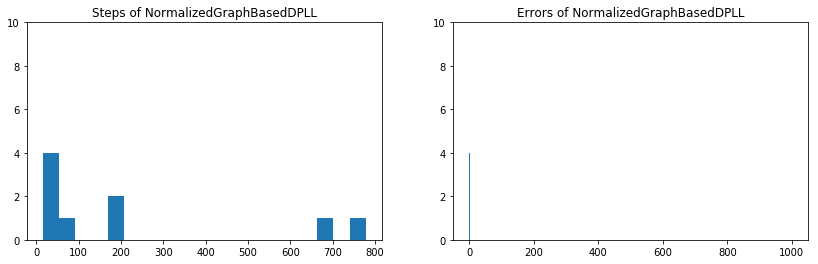

100%|██████████| 10/10 [00:13<00:00,  1.32s/it]


Within 1000 steps solved 9 problems out of 10
#Sats: 9; avg step: 214.44; stdev step: 252.46; avg error: 2.56; stdev error: 1.57


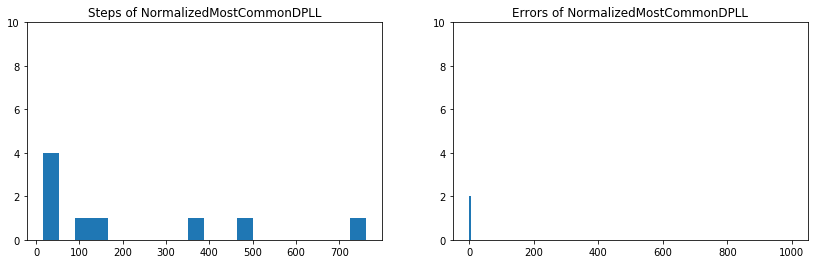

In [25]:
print_all(10, 1000, 50, light=True)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [09:40<00:00, 50.54s/it]


Within 1000 steps solved 6 problems out of 10
#Sats: 6; avg step: 91.67; stdev step: 80.97; avg error: 1.67; stdev error: 1.11


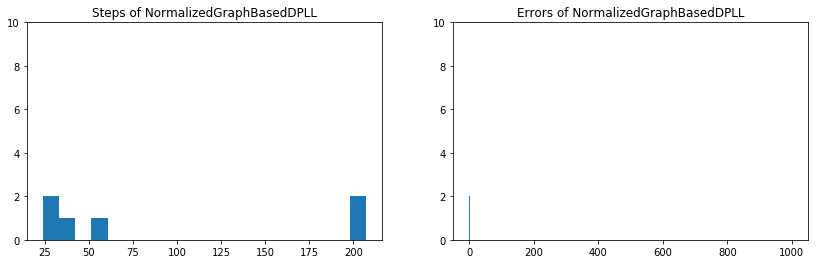

100%|██████████| 10/10 [01:20<00:00,  7.92s/it]


Within 1000 steps solved 2 problems out of 10
#Sats: 2; avg step: 891.50; stdev step: 79.50; avg error: 5.00; stdev error: 1.00


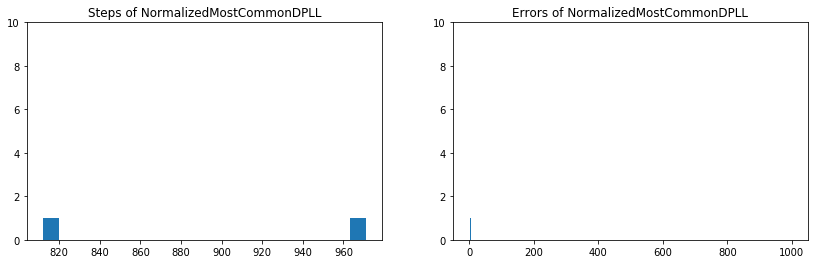

In [26]:
print_all(10, 1000, 70, light=True)

  0%|          | 0/3 [00:00<?, ?it/s]

We have generated 3 formulas


100%|██████████| 3/3 [03:21<00:00, 54.26s/it]


Within 1000 steps solved 2 problems out of 3
#Sats: 2; avg step: 312.50; stdev step: 201.50; avg error: 3.50; stdev error: 0.50


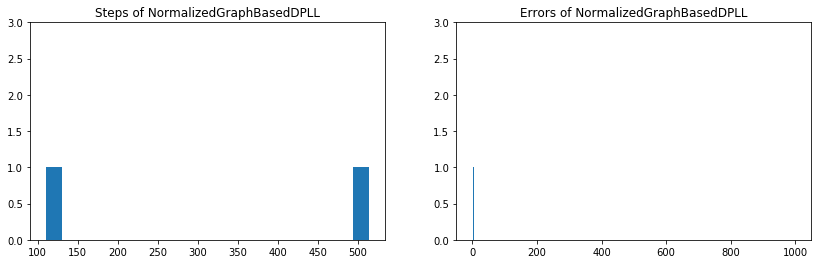

100%|██████████| 3/3 [00:33<00:00, 11.36s/it]
/home/michal/deepsat/venv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/michal/deepsat/venv/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/michal/deepsat/venv/lib/python3.5/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/michal/deepsat/venv/lib/python3.5/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/michal/deepsat/venv/lib/python3.5/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Within 1000 steps solved 0 problems out of 3
#Sats: 0; avg step: nan; stdev step: nan; avg error: nan; stdev error: nan


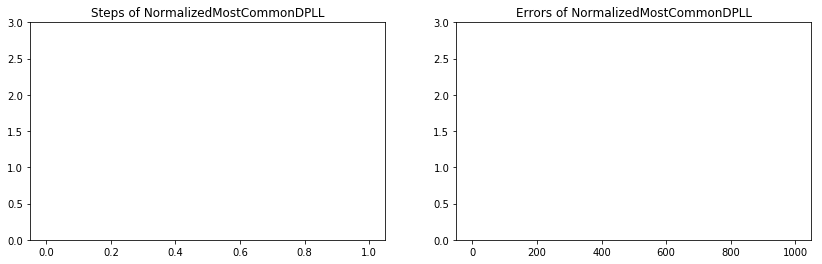

In [27]:
print_all(3, 1000, 90, light=True)